# Support Vector Machine Model on Spotify Features

## Introduction

In this notebook, we will use the pre-extracted features from Spotify to train our model. We will try to predict the genre using just these features as the Spotify algorithm uses them to recommend music to listeners. We are going to use 10 genres and approximately 400 songs per genre in order to train the model.

The first step is importing the libraries required for this endeavour.

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import seaborn as sns

## Loading the Dataset

We have already pinged the Spotify API to download the relevant songs from the artists and created a csv file called `subsampled` which we will load here. We will also look at the counts of the relevant genres to see if further balancing is required.



In [53]:
music = pd.read_csv("subsampled.csv")
music['Genre'].value_counts()

Classical    548
Pop          492
Rap          468
Blues        441
Rock         422
Hip-Hop      420
Qawwali      291
Ghazal       159
EDM          144
Metal        113
Name: Genre, dtype: int64

## Balancing the dataset through stratification

Unfortunately, there aren't enough files for EDM, Ghazal, Metal and Qawwali. Since some tracks did not have a Preview URL because of location and other restrictions, they could not be downloaded and their features could not be extracted. Thus, they were excluded from the dataset.Thus, the sample set of these genres has been reduced dramatically. In order to overcome this limitation, we will use stratification i.e. we will stratify by class as the future dataset on which this prediction will be made has the same distribution

In [55]:
X = music.iloc[:,7:-1].values

## Extracting Genres
y = music['Genre']

# split into training data (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, shuffle = True, random_state=0)

Now that we've stratified and split the dataset, we can get to training the model. In the first step, we will train the model without any hyperparameter tuning using the default parameters for `SVC` i.e. `Kernel` = `RBF` and `C` = 1. Then, we will test the accuracy to see if this model, without any tuning is good at predicting the genres based on Spotify's features

In [57]:
# Standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

#create parameter grid for tuning
svm = SVC(kernel = 'rbf', C=1, random_state = 0)
svm.fit(X_train_standardized,y_train)
y_predicted = svm.predict(X_test_standardized)
## 
print("Accuracy :\n", accuracy_score(y_true=y_test, y_pred=y_predicted))

Accuracy :
 0.46


The accuracy of the model is only 46%. It seems that there are some limitations with using just spotify features to predict a track's genre. We will now try hyperparameter tuning to see if the accuracy is improved in any way. In order to do so, we will consider multiple values for `C`, `gamma` and will also let the tuning determine the `kernel` to be used in the final model. After the tuning is done, we will use the best parameters to estimate the result once again.

In [48]:
param_grid = { 'C':[0.1,1,100],'kernel':['rbf','sigmoid','linear'],'gamma': [1, 0.1, 0.01]}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs= -1)

# train SVM
grid_model_result = grid.fit(X_train_standardized, y_train)

#extracting best parameters
best_params = grid.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [58]:
y_predicted = grid_model_result.best_estimator_.predict(X_test_standardized)
print("Accuracy :\n", accuracy_score(y_true=y_test, y_pred=y_predicted))

Accuracy :
 0.4828571428571429


In [59]:
results = pd.DataFrame(X_test.copy())
results.loc[:, 'genre'] = list(y_test)
results.loc[:, 'preds'] = y_predicted.copy()
results_wrong = results[results['genre'] != results['preds']]
results_wrong['genre'].value_counts(normalize=True)

Hip-Hop      0.198895
Pop          0.171271
Blues        0.143646
Qawwali      0.116022
Rap          0.116022
Rock         0.066298
Ghazal       0.060773
EDM          0.055249
Metal        0.055249
Classical    0.016575
Name: genre, dtype: float64

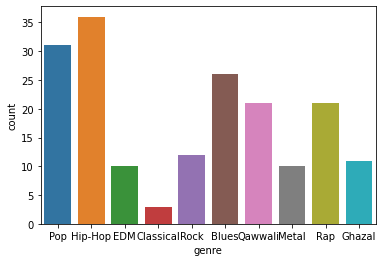

In [60]:
sns.countplot( x = results_wrong['genre'])